# DDPG with Crawler

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
# Imports

from IPython.display import YouTubeVideo
#from mlagents_envs.environment import UnityEnvironment
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
YouTubeVideo('https://www.youtube.com/watch?v=tmoz3ojbTn0&ab_channel=Unity')

In [4]:
YouTubeVideo('https://www.youtube.com/watch?v=fiQsmdwEGT8&feature=emb_logo&ab_channel=Unity') 

In [5]:
env = UnityEnvironment(file_name="Crawler_Windows_x86_64/Crawler.exe", seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

In [9]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=200, fc2_units=150):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
## Agent and Critic 
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

eps_start= 1.0
eps_end = 0.01
eps_decay = 1e-6
SEED = 10 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise((num_agents,action_size), random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(state.shape[0]):
            self.memory.add(state[i, :], action[i], reward[i], next_state[i, :], done[i])
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)        
        
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action = action+self.noise.sample()    
        return np.clip(action, -1, 1) 

        
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
# Looking at the state action space

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 9.99999225e-01  1.27272622e-03  0.00000000e+00  2.25000000e+00
  1.00000036e+00 -3.22882910e-12 -1.19209290e-07  3.22882975e-12
  1.00000000e+00 -3.22882910e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  5.00000000e-01
  5.00000000e-01  0.00000000e+00  5.00000000e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339918e+00 -1.42857209e-01
 -1.33341408e+00  5.00000000e-01  0.00000000e+00  0.00000000e+00
  5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

In [14]:
## Random samples


env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations            # get the current state
score = 0                                          # initialize the score
#env.viewer = None
#env.render()
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 20.25765499426052


## DDPG

In [11]:
scores = []                        # list containing scores from each episode
def ddpg(n_episodes=30000):
    """Deep Deterministic Policy Gradient.
    
    Args
        n_episodes (int): maximum number of training episodes
    Return:
        scores (average score)

    """
    scores_window = deque(maxlen=100)  # last 100 scores

    agents=Agent(state_size, action_size, num_agents, SEED)
    actor_file_local = 'checkpoint_agent.pth'
    critic_file_local = 'checkpoint_critic.pth'
    agents.actor_local.load_state_dict(torch.load(actor_file_local))
    agents.critic_local.load_state_dict(torch.load(critic_file_local))
    agents.actor_local.train()
    agents.critic_local.train()
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        while True:
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            
            agents.step(state, action, rewards, next_state, dones)
            score += rewards                                # update the score
            state = next_state                             # roll over the state to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break
        scores_window.append(np.mean(score))       # save most recent score
        scores.append(np.mean(score))              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0 or i_episode % 500 ==0:
            print('Average Score: {:.2f}'.format( np.mean(scores_window)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_agent.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
    return scores

In [12]:
scores = ddpg()

c:\users\singh\appdata\local\continuum\anaconda3\envs\unityml\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.51
Episode 200	Average Score: -0.10
Episode 300	Average Score: 0.390
Episode 400	Average Score: 2.18
Episode 500	Average Score: 2.43
Average Score: 2.43
Episode 600	Average Score: 3.51
Episode 700	Average Score: 1.51
Episode 800	Average Score: 1.50
Episode 900	Average Score: 1.42
Episode 1000	Average Score: 5.97
Average Score: 5.97
Episode 1100	Average Score: 5.12
Episode 1200	Average Score: 6.51
Episode 1300	Average Score: 6.75
Episode 1400	Average Score: 7.13
Episode 1500	Average Score: 8.55
Average Score: 8.55
Episode 1600	Average Score: 10.28
Episode 1700	Average Score: 11.37
Episode 1800	Average Score: 13.18
Episode 1900	Average Score: 13.51
Episode 2000	Average Score: 16.88
Average Score: 16.88
Episode 2100	Average Score: 16.95
Episode 2200	Average Score: 18.46
Episode 2300	Average Score: 16.69
Episode 2400	Average Score: 16.49
Episode 2500	Average Score: 16.87
Average Score: 16.87
Episode 2600	Average Score: 17.16
Episode 2700	Average Score: 16.19
Ep

Episode 21300	Average Score: 25.61
Episode 21400	Average Score: 25.00
Episode 21500	Average Score: 16.92
Average Score: 16.92
Episode 21600	Average Score: 17.89
Episode 21700	Average Score: 15.98
Episode 21800	Average Score: 24.03
Episode 21900	Average Score: 24.52
Episode 22000	Average Score: 23.43
Average Score: 23.43
Episode 22100	Average Score: 20.76
Episode 22200	Average Score: 23.78
Episode 22300	Average Score: 24.41
Episode 22400	Average Score: 25.31
Episode 22500	Average Score: 26.41
Average Score: 26.41
Episode 22600	Average Score: 25.00
Episode 22700	Average Score: 27.52
Episode 22800	Average Score: 22.10
Episode 22900	Average Score: 26.33
Episode 23000	Average Score: 21.38
Average Score: 21.38
Episode 23100	Average Score: 18.41
Episode 23200	Average Score: 23.37
Episode 23300	Average Score: 28.20
Episode 23329	Average Score: 30.14Average Score: 30.14
Episode 23330	Average Score: 30.15Average Score: 30.15
Episode 23331	Average Score: 30.24Average Score: 30.24
Episode 23332	Av

Episode 29371	Average Score: 30.56Average Score: 30.56
Episode 29372	Average Score: 30.55Average Score: 30.55
Episode 29373	Average Score: 30.68Average Score: 30.68
Episode 29374	Average Score: 31.01Average Score: 31.01
Episode 29375	Average Score: 31.09Average Score: 31.09
Episode 29376	Average Score: 31.35Average Score: 31.35
Episode 29377	Average Score: 31.18Average Score: 31.18
Episode 29378	Average Score: 31.25Average Score: 31.25
Episode 29379	Average Score: 31.12Average Score: 31.12
Episode 29380	Average Score: 30.71Average Score: 30.71
Episode 29381	Average Score: 30.66Average Score: 30.66
Episode 29382	Average Score: 30.49Average Score: 30.49
Episode 29383	Average Score: 30.47Average Score: 30.47
Episode 29384	Average Score: 30.50Average Score: 30.50
Episode 29385	Average Score: 30.38Average Score: 30.38
Episode 29386	Average Score: 30.56Average Score: 30.56
Episode 29387	Average Score: 30.30Average Score: 30.30
Episode 29391	Average Score: 30.21Average Score: 30.21
Episode 29

## Plotting the results

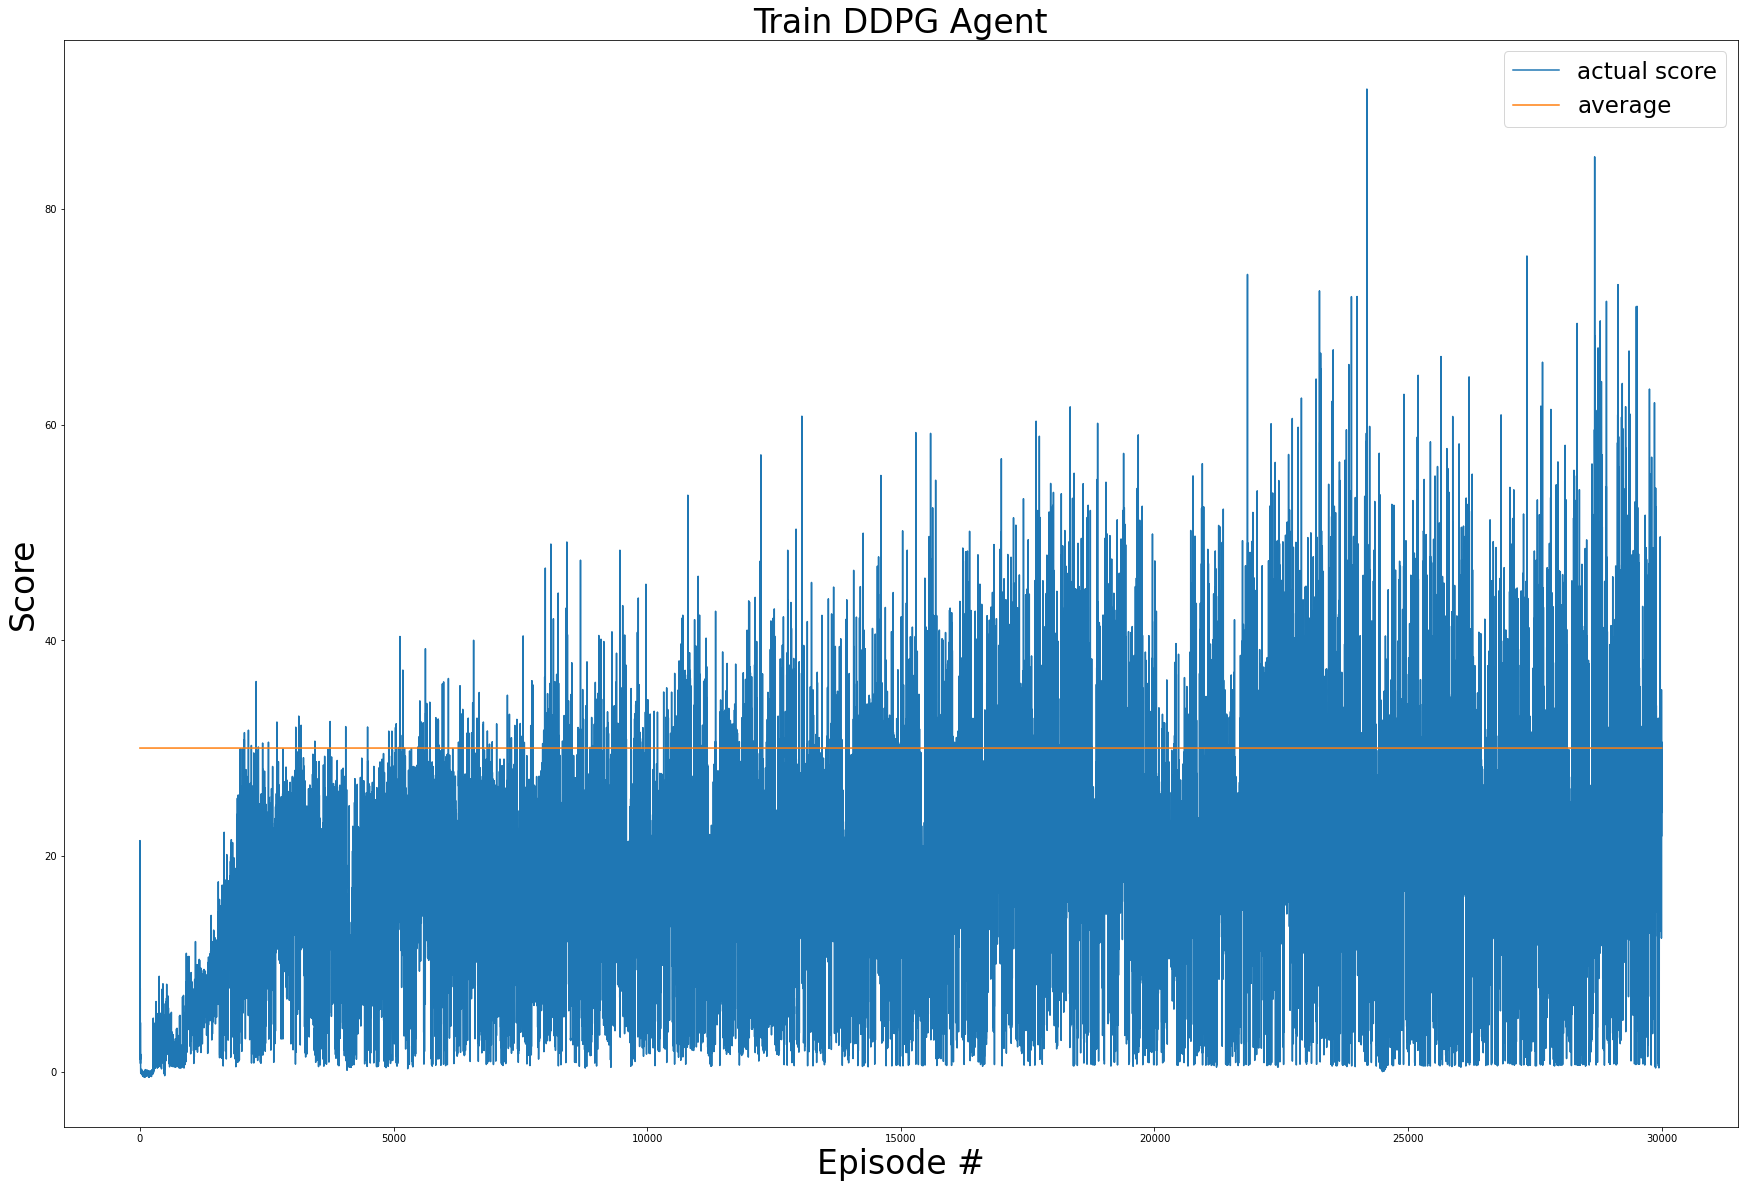

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt 

#def __init__(self, state_size, action_size, random_seed):
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
#scores = ddpg(agent)

# plot the scores
average_score = 30
success = [average_score] * len(scores)
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores,np.arange(len(scores)), success)
plt.ylabel('Score', fontsize = 33)
plt.xlabel('Episode #', fontsize = 33)
plt.title('Train DDPG Agent', fontsize = 33)
plt.gca().legend(('actual score','average'), fontsize = 23)
plt.show()

## Testing the model

In [12]:

actor_file_local = 'DDPG/twenty-four_ckpt/checkpoint_agent.pth'
critic_file_local = 'DDPG/twenty-four_ckpt/checkpoint_critic.pth'

final_eps = 0.01

agents = Agent(state_size,action_size, num_agents, SEED)
    
# load the weights from file
#agent.qnetwork_local.load_state_dict(torch.load(filename_to_load))

#Since the model is trained on gpu, need to load all gpu tensors to cpu:
agents.actor_local.load_state_dict(torch.load(actor_file_local))
agents.critic_local.load_state_dict(torch.load(critic_file_local))
# agents.actor_target.load_state_dict(torch.load(actor_file_target))
# agents.critic_target.load_state_dict(torch.load(critic_file_target))



#print([p for p in agent.qnetwork_local.parameters()])

# #debug
# state = env.reset()
# print(agent.qnetwork_local(state))
# print(agent.qnetwork_local.forward(state))
# #end debug
state = env.reset()
agents.reset() 
num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agents.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations   # get the next state
        rewards = env_info.rewards                   # get the reward
        dones = env_info.local_done                  # see if episode has finished

                                       # update the score
        state = next_state                             # roll over the state to next time step
        if np.any(dones):                                       # exit loop if episode finished
            break


In [15]:
env.close()